<img src="https://github.com/djp840/MSDS_453_Public/blob/main/images/NorthwesternHeader.png?raw=1">

## MSDS453 - Research Assignment 03 - Ontology Plus Context and Modeling

Take the ontology that you developed in week 6 and consider how your ten chosen documents for this quarter's class corpus map to that ontology.

Protégé is a tool that takes inputs for a human-created Ontology and creates a visualization.

Use Python algorithms to generate Knowledge Graphs from your documents.

TensorFlow Bidirectional RNN Model

In [1]:
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from collections import Counter
from dataclasses import dataclass
from timeit import default_timer as timer

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import gensim
from gensim.models import Word2Vec

import spacy
from spacy import displacy

from spacy.matcher import Matcher
from spacy.tokens import Span

import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import display, HTML

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
tf.random.set_seed(2022)
import tensorflow.keras.backend as k

from typing import List, Callable, Dict, Tuple, Set

<div class="alert alert-block alert-danger">
<b>Required Installation: en_core_web_lg</b><br>"python -m spacy download en_core_web_lg"<br><br>English pipeline optimized for CPU. Components: tok2vec, tagger, parser, senter, ner, attribute_ruler, lemmatizer<br>
    <b>https://spacy.io/models/en#en_core_web_lg </b>
</div>

## Requires Restart Of Runtime After Installation

In [2]:
!python -m spacy download en_core_web_lg -q

2023-11-22 04:39:23.643528: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-22 04:39:23.643592: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-22 04:39:23.643639: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-22 04:39:26.202562: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [3]:
nlp = spacy.load('en_core_web_lg')

### Mount Google Drive to Colab Environment

In [4]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [5]:
#! ls -l /content/gdrive

### NLTK Downloads

In [6]:
# Only run this once, they will be downloaded.
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('punkt',quiet=True)
nltk.download('omw-1.4',quiet=True)

True

<div class="alert alert-block alert-danger">
<b>Gensim</b> is a Python library for topic modelling, document indexing and similarity retrieval with large corpora. Target audience is the natural language processing (NLP) and information retrieval (IR) community <br><br>
    <b>https://pypi.org/project/gensim/ </b>
</div>

In [7]:
import pkg_resources
#pkg_resources.require("gensim<=3.8.3");

In [8]:
print("Genism Version: ", gensim.__version__)

Genism Version:  4.3.2


<div class="alert alert-block alert-info">
    <b>Suppress warning messages</b></div>

In [9]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Data Wrangling Utility Functions

In [10]:
def add_movie_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    """
    Adds "Movie Description" to the supplied dataframe, in the form {Genre}_{P|N}_{Movie Title}_{DocID}
    """
    review = np.where(corpus_df['Review Type (pos or neg)'] == 'Positive', 'P', 'N')
    data['Descriptor'] = corpus_df['Genre of Movie'] + '_' + corpus_df['Movie Title'] + '_' + review + '_' + corpus_df['Doc_ID'].astype(str)

def get_corpus_df(path: str) -> pd.DataFrame:
    data = pd.read_csv(path,encoding="utf-8")
    add_movie_descriptor(data, data)
    sorted_data = data.sort_values(['Descriptor'])
    indexed_data = sorted_data.set_index(['Doc_ID'])
    indexed_data['Doc_ID'] = indexed_data.index
    return indexed_data

def remove_punctuation(text: str) -> str:
    return re.sub('[^a-zA-Z]', '', str(text))

def remove_tags(text: str) -> str:
    return re.sub('&lt;/?.*?&gt;', '', text)

def remove_special_chars_and_digits(text: str) -> str:
    return re.sub('(\\d|\\W)+', '', text)

def get_sentences(text: str) -> List[str]:
    return [str(x) for x in nlp(text).sents]

def get_coref_resolved_sentences(text: str) -> List[str]:
    return [str(x) for x in nlp(text).sents]

def get_lemmas(text: str, stopwords: Set[str]) -> List[str]:
    initial = [remove_tags(remove_special_chars_and_digits(remove_punctuation(x.lemma_.lower()))) for x in nlp(text)]
    return [x for x in initial if x not in stopwords]

def lemmatize_sentence(text: str, stopwords: Set[str]) -> str:
    return ' '.join(get_lemmas(text, stopwords))

def clean_doc(doc):
    #doc = remove_punctuation(doc)
    doc= ' '.join(remove_stop_words(doc))
    doc = apply_lemmatization(doc)
    return doc

def remove_stop_words(in_text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(in_text)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    return filtered_sentence

def apply_lemmatization(in_text):
    # Lemmatization
    lem = WordNetLemmatizer()
    word_list = nltk.word_tokenize(in_text)
    output = ' '.join([lem.lemmatize(w) for w in word_list])
    return output

def counter_word(text):
  count=Counter()
  for i in text.values:
    for word in i.split():
      count[word]=+1
  return count

## Knowledge Context Graph Functions

In [11]:
def map_edges(map_to: str, map_from: Set[str], df: pd.DataFrame):
    print(f'Before mapping {", ".join(map_from)} -> {map_to}: {sum(df.edge == map_to)}')
    df['edge'] = np.where(kg_df.edge.isin(map_from), map_to, kg_df.edge)
    print(f'After mapping {", ".join(map_from)} -> {map_to}: {sum(df.edge == map_to)}')

def map_sources_and_targets(map_to: str, map_from: Set[str], df: pd.DataFrame):
    before = sum(df.source == map_to) + sum(df.target == map_to)
    print(f'Before mapping {", ".join(map_from)} -> {map_to}: {before}')

    df['source'] = np.where(kg_df.source.isin(map_from), map_to, kg_df.source)
    df['target'] = np.where(kg_df.target.isin(map_from), map_to, kg_df.target)

    after = sum(df.source == map_to) + sum(df.target == map_to)
    print(f'After mapping {", ".join(map_from)} -> {map_to}: {after}')

def get_neighborhood(sources: Set[str], edge_types: Set[str], depth: int, df: pd.DataFrame) -> pd.DataFrame:
    output = []

    for d in range(depth):
        if edge_types is not None:
            rows = df[(df.edge.isin(edge_types)) & ((df.source.isin(sources)) | (df.target.isin(sources)))].copy()
        else:
            rows = df[(df.source.isin(sources)) | (df.target.isin(sources))].copy()

        output.append(rows)
        sources = set(rows.target).union(set(rows.source))

    return pd.concat(output).drop_duplicates()

def find_sources_and_targets_with_patterns(patterns: List[str], df: pd.DataFrame):
    mask = np.zeros(kg_df.shape[0])
    for pattern in patterns:
        mask = mask | (df.source.str.contains(pattern)) | (df.target.str.contains(pattern))

    return df[mask]
# Examples of how to use the function:
# find_sources_and_targets_with_patterns(['action'], kg_df)
# find_sources_and_targets_with_patterns(['terror'], kg_df)
# find_sources_and_targets_with_patterns(['novel'], kg_df)
# find_sources_and_targets_with_patterns(['director', 'campbell'], kg_df)


def plot_graph(df: pd.DataFrame, show_edges: bool = False, figsize: Tuple[int, int] = (12, 12), use_circular: bool=True):
    graph = nx.from_pandas_edgelist(df, "source", "target", edge_attr='edge', create_using=nx.MultiDiGraph())

    plt.figure(figsize=figsize)
    if use_circular:
        pos = nx.circular_layout(graph)
    else:
        pos = nx.kamada_kawai_layout(graph)

    nx.draw(graph, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
    if show_edges:
        nx.draw_networkx_edge_labels(graph, pos=pos, font_size=8)

    plt.show()

def get_top_sources_and_targets(df: pd.DataFrame, top: int = 10):
    return (Counter(df.source) + Counter(df.target)).most_common(top)

def get_top_edges(df: pd.DataFrame, top: int = 10):
    return Counter(df.edge).most_common(top)

def get_dataset_partitions_pd(df, train_split=0.8, val_split=0.10, test_split=0.10):
       # Specify seed to always have the same split distribution between runs
    df_sample = df.sample(frac=1, random_state=12)
    indices_or_sections = [int(.8*len(df)), int(.9*len(df))]
    train_ds, val_ds, test_ds = np.split(df_sample, indices_or_sections)
    return train_ds, val_ds, test_ds

## Entity Extraction Functions

In [12]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text

      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text

      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text

      ## chunk 5
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text

  return [ent1.strip(), ent2.strip()]

def get_relation(sent):
    try:
        doc = nlp(sent)

        # Matcher class object
        matcher = Matcher(nlp.vocab)

        #define the pattern
        pattern = [{'DEP':'ROOT'},
                {'DEP':'prep','OP':"?"},
                {'DEP':'agent','OP':"?"},
                {'POS':'ADJ','OP':"?"}]
        matcher.add("matching_1", [pattern])
        matches = matcher(doc)
        k = len(matches) - 1
        span = doc[matches[k][1]:matches[k][2]]

        return(span.text)
    except:
        pass

def get_subject_verb_object(sent):
  ent1 = ""
  ent2 = ""
  root = ""

  for tok in nlp(sent):
      if tok.dep_ == 'ROOT':
        root = tok.text
      elif tok.dep_ == "nsubj":
        ent1 = tok.text
      elif tok.dep_ == "dobj":
        ent2 = tok.text

      if ent1 != '' and ent2 != '' and root != '':
        break

  return [ent1, root, ent2]

## Visualization Utility Functions

In [13]:
def plot_confusion_matrix_labeled(y_true, y_pred, CLASSES_LIST):
    mtx = confusion_matrix(y_true, y_pred)
    # define classes
    classes = CLASSES_LIST
    temp_df = pd.DataFrame(data=mtx,columns=classes)
    temp_df.index = classes
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(temp_df, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

## Loading the Class Corpus

In [14]:
CORPUS_PATH=\
'https://raw.githubusercontent.com/barrycforever/MSDS_453_Public/main/MSDS453_ClassCorpus/MSDS453_ClassCorpus_Final_Sec57_v2_20230928.csv'
corpus_df = get_corpus_df(CORPUS_PATH)

## Exploratory Data Analysis

In [15]:
# Tokenize sentences
corpus_df['raw_sentences'] = corpus_df.Text.apply(get_sentences)
corpus_df.head(3).T

Doc_ID,90,91,92
DSI_Title,LKP_Doc1_Angel_has_fallen,LKP_Doc2_Angel_has_fallen,LKP_Doc3_Angel_has_fallen
Text,Target is on the move . '' Heavily outnumbered...,"The sleepy , dopey action bonanza `` Angel Has...",`` Angel Has Fallen '' marks the third time th...
Submission File Name,LKP_Doc1_Angel_has_fallen,LKP_Doc2_Angel_has_fallen,LKP_Doc3_Angel_has_fallen
Student Name,LKP,LKP,LKP
Genre of Movie,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,Angel_has_fallen,Angel_has_fallen,Angel_has_fallen
Descriptor,Action_Angel_has_fallen_N_90,Action_Angel_has_fallen_N_91,Action_Angel_has_fallen_N_92
Doc_ID,90,91,92
raw_sentences,"[Target is on the move . '', Heavily outnumber...","[The sleepy , dopey action bonanza `` Angel Ha...",[`` Angel Has Fallen '' marks the third time t...


## Tokenize Words

In [16]:
default_stopwords=\
set(nltk.corpus.stopwords.words('english')).union(set(nlp.Defaults.stop_words)).union({' ', ''})
corpus_df['lemmas'] = corpus_df.Text.apply(lambda x: get_lemmas(x, default_stopwords))
corpus_df.lemmas.head()

Doc_ID
90    [target, heavily, outnumber, outgunne, mike, b...
91    [sleepy, dopey, action, bonanza, angel, fall, ...
92    [angel, fall, mark, time, gerard, butler, secr...
93    [improve, blandness, mike, banning, gerard, bu...
94    [review, contain, spoiler, angel, fallen, movi...
Name: lemmas, dtype: object

In [17]:
corpus_df.head(3).T

Doc_ID,90,91,92
DSI_Title,LKP_Doc1_Angel_has_fallen,LKP_Doc2_Angel_has_fallen,LKP_Doc3_Angel_has_fallen
Text,Target is on the move . '' Heavily outnumbered...,"The sleepy , dopey action bonanza `` Angel Has...",`` Angel Has Fallen '' marks the third time th...
Submission File Name,LKP_Doc1_Angel_has_fallen,LKP_Doc2_Angel_has_fallen,LKP_Doc3_Angel_has_fallen
Student Name,LKP,LKP,LKP
Genre of Movie,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,Angel_has_fallen,Angel_has_fallen,Angel_has_fallen
Descriptor,Action_Angel_has_fallen_N_90,Action_Angel_has_fallen_N_91,Action_Angel_has_fallen_N_92
Doc_ID,90,91,92
raw_sentences,"[Target is on the move . '', Heavily outnumber...","[The sleepy , dopey action bonanza `` Angel Ha...",[`` Angel Has Fallen '' marks the third time t...


## Reassemble Leminized Words

In [18]:
corpus_df['lemmas_joined'] = corpus_df.lemmas.apply(lambda x: ' '.join(x))

In [19]:
corpus_df['lemmas_joined'].head()

Doc_ID
90    target heavily outnumber outgunne mike banning...
91    sleepy dopey action bonanza angel fall disappo...
92    angel fall mark time gerard butler secret serv...
93    improve blandness mike banning gerard butler w...
94    review contain spoiler angel fallen movie extr...
Name: lemmas_joined, dtype: object

In [20]:
corpus_df.head(3).T

Doc_ID,90,91,92
DSI_Title,LKP_Doc1_Angel_has_fallen,LKP_Doc2_Angel_has_fallen,LKP_Doc3_Angel_has_fallen
Text,Target is on the move . '' Heavily outnumbered...,"The sleepy , dopey action bonanza `` Angel Has...",`` Angel Has Fallen '' marks the third time th...
Submission File Name,LKP_Doc1_Angel_has_fallen,LKP_Doc2_Angel_has_fallen,LKP_Doc3_Angel_has_fallen
Student Name,LKP,LKP,LKP
Genre of Movie,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,Angel_has_fallen,Angel_has_fallen,Angel_has_fallen
Descriptor,Action_Angel_has_fallen_N_90,Action_Angel_has_fallen_N_91,Action_Angel_has_fallen_N_92
Doc_ID,90,91,92
raw_sentences,"[Target is on the move . '', Heavily outnumber...","[The sleepy , dopey action bonanza `` Angel Ha...",[`` Angel Has Fallen '' marks the third time t...


## Vocabulary Data Wrangling

In [21]:
vectorizer = CountVectorizer(ngram_range=(1, 1))
transformed_documents = vectorizer.fit_transform(corpus_df.lemmas_joined)
doc_term_matrix = transformed_documents.todense()
doc_term_df = pd.DataFrame(doc_term_matrix,
                           columns=vectorizer.get_feature_names_out(),
                           index=corpus_df.Descriptor)
print(f'All Word Vocabulary size: {doc_term_df.shape[1]}')
all_words = set(doc_term_df.columns)

vectorizer = CountVectorizer(ngram_range=(1, 1), min_df=5, max_df=.8)
transformed_documents = vectorizer.fit_transform(corpus_df.lemmas_joined)
doc_term_matrix = transformed_documents.todense()
doc_term_df = pd.DataFrame(doc_term_matrix,
                           columns=vectorizer.get_feature_names_out(),
                           index=corpus_df.Descriptor)
print(f'Curated Vocabulary size: {doc_term_df.shape[1]}')
vocabulary = set(doc_term_df.columns)

words_to_remove = default_stopwords.union(all_words - vocabulary)

All Word Vocabulary size: 8802
Curated Vocabulary size: 1774


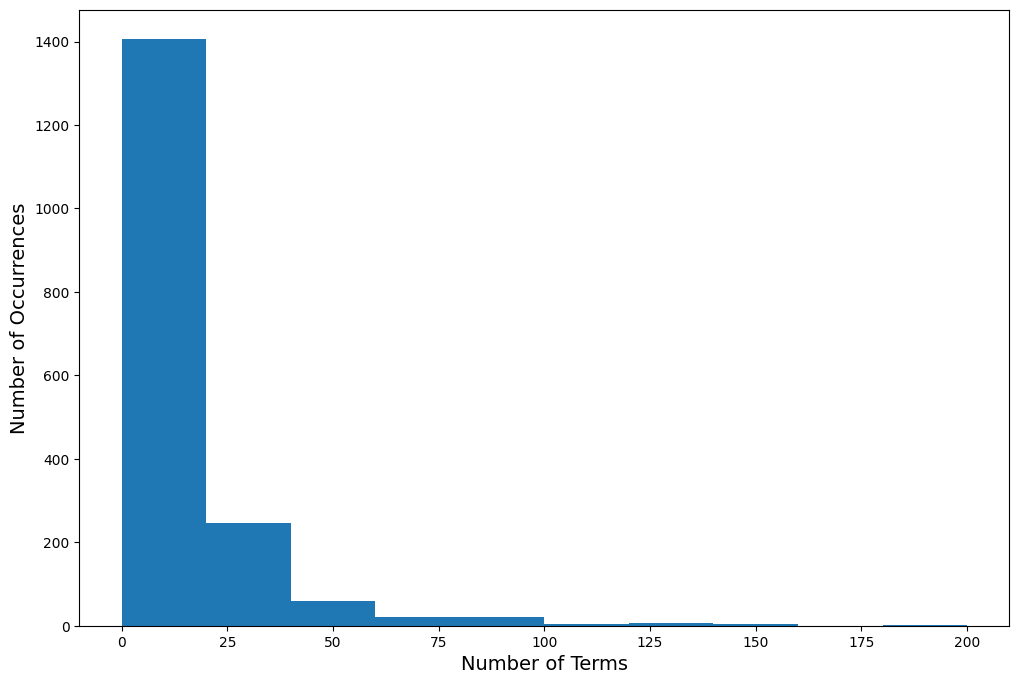

In [22]:
plt.figure(figsize = (12, 8))
plt.hist(doc_term_df.sum(axis=0), range=(0, 200))
plt.ylabel('Number of Occurrences',fontsize=14)
plt.xlabel('Number of Terms',fontsize=14);

In [23]:
# Re-tokenize words, recreate joined documents
corpus_df['lemmas'] = corpus_df.Text.apply(lambda x: get_lemmas(x, words_to_remove))
corpus_df['lemmas_joined'] = corpus_df.lemmas.apply(lambda x: ' '.join(x))
corpus_df.lemmas.head()

Doc_ID
90    [target, heavily, mike, banning, gerard, butle...
91    [action, angel, fall, reason, expect, second, ...
92    [angel, fall, mark, time, gerard, butler, secr...
93    [mike, banning, gerard, butler, accept, promot...
94    [review, contain, spoiler, angel, fallen, movi...
Name: lemmas, dtype: object

## Get Lemmatized and Filtered Sentences

Removes the additional words

In [24]:
corpus_df['sentences_lemmatized']=\
corpus_df.raw_sentences.apply(lambda x: [lemmatize_sentence(s, words_to_remove) for s in x])

In [25]:
corpus_df.head().T

Doc_ID,90,91,92,93,94
DSI_Title,LKP_Doc1_Angel_has_fallen,LKP_Doc2_Angel_has_fallen,LKP_Doc3_Angel_has_fallen,LKP_Doc4_Angel_has_fallen,LKP_Doc5_Angel_has_fallen
Text,Target is on the move . '' Heavily outnumbered...,"The sleepy , dopey action bonanza `` Angel Has...",`` Angel Has Fallen '' marks the third time th...,Improving through blandness . So Mike Banning ...,This review may contain spoilers . Angel Has F...
Submission File Name,LKP_Doc1_Angel_has_fallen,LKP_Doc2_Angel_has_fallen,LKP_Doc3_Angel_has_fallen,LKP_Doc4_Angel_has_fallen,LKP_Doc5_Angel_has_fallen
Student Name,LKP,LKP,LKP,LKP,LKP
Genre of Movie,Action,Action,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative,Negative,Negative
Movie Title,Angel_has_fallen,Angel_has_fallen,Angel_has_fallen,Angel_has_fallen,Angel_has_fallen
Descriptor,Action_Angel_has_fallen_N_90,Action_Angel_has_fallen_N_91,Action_Angel_has_fallen_N_92,Action_Angel_has_fallen_N_93,Action_Angel_has_fallen_N_94
Doc_ID,90,91,92,93,94
raw_sentences,"[Target is on the move . '', Heavily outnumber...","[The sleepy , dopey action bonanza `` Angel Ha...",[`` Angel Has Fallen '' marks the third time t...,"[Improving through blandness ., So Mike Bannin...","[This review may contain spoilers ., Angel Has..."


## Review Documents By Movie Title

In [26]:
print(corpus_df['Movie Title'].unique())

['Angel_has_fallen' 'Inception' 'No_Time_to_Die' 'Taken' 'Taxi' 'Barbie'
 'Dirty_Grandpa' 'Holmes_and_Watson' 'Lost City' 'Mean_Girls'
 'Drag_Me_To_Hell' 'Fresh' 'It_Chapter_Two' 'The Conjuring 2' 'The_Others'
 'EQUILIBRIUM' 'Minority_Report' 'Oblivion' 'Pitch_Black' 'The_Batman']


In [27]:
movie_df = corpus_df[corpus_df['Movie Title'] == 'EQUILIBRIUM'].copy()
# or
#movie_df = corpus_df[corpus_df['Movie Title'] == 'Dirty_Grandpa'].copy()
movie_df.head(10).T

Doc_ID,152,155,156,157,158,150,151,153,154,159
DSI_Title,BYM_Doc3_EQUILIBRIUM,BYM_Doc6_EQUILIBRIUM,BYM_Doc7_EQUILIBRIUM,BYM_Doc8_EQUILIBRIUM,BYM_Doc9_EQUILIBRIUM,BYM_Doc1_EQUILIBRIUM,BYM_Doc2_EQUILIBRIUM,BYM_Doc4_EQUILIBRIUM,BYM_Doc5_EQUILIBRIUM,BYM_Doc10_EQUILIBRIUM
Text,"A tedious rip-off sci-fi film , itching to be ...",`` Equilibrium '' is like a remake of `` 1984 ...,An unsophisticated sci-fi drama that takes its...,Science fiction is a good genre for creating v...,The worst theatrically released sci-fi flick s...,Equilibrium is my favorite movie of 2002 . It ...,If I was to explain this movie to someone in o...,If you were disappointed by recent sci-fi acti...,`` Equilibrium '' would be a mindless action p...,"In the first years of the 21st century , a thi..."
Submission File Name,BYM_Doc3_EQUILIBRIUM,BYM_Doc6_EQUILIBRIUM,BYM_Doc7_EQUILIBRIUM,BYM_Doc8_EQUILIBRIUM,BYM_Doc9_EQUILIBRIUM,BYM_Doc1_EQUILIBRIUM,BYM_Doc2_EQUILIBRIUM,BYM_Doc4_EQUILIBRIUM,BYM_Doc5_EQUILIBRIUM,BYM_Doc10_EQUILIBRIUM
Student Name,BYM,BYM,BYM,BYM,BYM,BYM,BYM,BYM,BYM,BYM
Genre of Movie,Sci-Fi,Sci-Fi,Sci-Fi,Sci-Fi,Sci-Fi,Sci-Fi,Sci-Fi,Sci-Fi,Sci-Fi,Sci-Fi
Review Type (pos or neg),Negative,Negative,Negative,Negative,Negative,Positive,Positive,Positive,Positive,Positive
Movie Title,EQUILIBRIUM,EQUILIBRIUM,EQUILIBRIUM,EQUILIBRIUM,EQUILIBRIUM,EQUILIBRIUM,EQUILIBRIUM,EQUILIBRIUM,EQUILIBRIUM,EQUILIBRIUM
Descriptor,Sci-Fi_EQUILIBRIUM_N_152,Sci-Fi_EQUILIBRIUM_N_155,Sci-Fi_EQUILIBRIUM_N_156,Sci-Fi_EQUILIBRIUM_N_157,Sci-Fi_EQUILIBRIUM_N_158,Sci-Fi_EQUILIBRIUM_P_150,Sci-Fi_EQUILIBRIUM_P_151,Sci-Fi_EQUILIBRIUM_P_153,Sci-Fi_EQUILIBRIUM_P_154,Sci-Fi_EQUILIBRIUM_P_159
Doc_ID,152,155,156,157,158,150,151,153,154,159
raw_sentences,"[A tedious rip-off sci-fi film , itching to be...",[`` Equilibrium '' is like a remake of `` 1984...,[An unsophisticated sci-fi drama that takes it...,[Science fiction is a good genre for creating ...,[The worst theatrically released sci-fi flick ...,"[Equilibrium is my favorite movie of 2002 ., I...",[If I was to explain this movie to someone in ...,[If you were disappointed by recent sci-fi act...,[`` Equilibrium '' would be a mindless action ...,"[In the first years of the 21st century , a th..."


## Recurrent Neural Network (RNN) Model Development

<img src="https://github.com/djp840/MSDS_453_Public/blob/main/images/BidirectionalRNN.png?raw=true">

<div class="alert alert-block alert-info">
    <b>tf.keras.layers.Bidirectional</b><br>
    https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional
    </div>

In [28]:
datafull=corpus_df.copy()
datafull.reset_index(drop=True, inplace=True)
datafull.head(4).T

,0,1,2,3
DSI_Title,LKP_Doc1_Angel_has_fallen,LKP_Doc2_Angel_has_fallen,LKP_Doc3_Angel_has_fallen,LKP_Doc4_Angel_has_fallen
Text,Target is on the move . '' Heavily outnumbered...,"The sleepy , dopey action bonanza `` Angel Has...",`` Angel Has Fallen '' marks the third time th...,Improving through blandness . So Mike Banning ...
Submission File Name,LKP_Doc1_Angel_has_fallen,LKP_Doc2_Angel_has_fallen,LKP_Doc3_Angel_has_fallen,LKP_Doc4_Angel_has_fallen
Student Name,LKP,LKP,LKP,LKP
Genre of Movie,Action,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative,Negative
Movie Title,Angel_has_fallen,Angel_has_fallen,Angel_has_fallen,Angel_has_fallen
Descriptor,Action_Angel_has_fallen_N_90,Action_Angel_has_fallen_N_91,Action_Angel_has_fallen_N_92,Action_Angel_has_fallen_N_93
Doc_ID,90,91,92,93
raw_sentences,"[Target is on the move . '', Heavily outnumber...","[The sleepy , dopey action bonanza `` Angel Ha...",[`` Angel Has Fallen '' marks the third time t...,"[Improving through blandness ., So Mike Bannin..."


In [29]:
datafull['Text'] = datafull['Text'].apply(lambda x :clean_doc(x))

## Preprocess DataSet

In [30]:
data = datafull[['Text','Genre of Movie', 'Review Type (pos or neg)']].copy()

In [31]:
data['Genre of Movie'] = data['Genre of Movie'].astype("category")
data['Review Type (pos or neg)'] = data['Review Type (pos or neg)'].astype("category")
data['Genre of Movie code'] = data['Genre of Movie'].cat.codes
data['Review Type (pos or neg) code'] = data['Review Type (pos or neg)'].cat.codes
data['Genre of Movie code'].tail().T

195    3
196    3
197    3
198    3
199    3
Name: Genre of Movie code, dtype: int8

In [32]:
data['Review Type (pos or neg) code'].tail(10).T

190    0
191    0
192    0
193    0
194    0
195    1
196    1
197    1
198    1
199    1
Name: Review Type (pos or neg) code, dtype: int8

## Review Examples by Genre

In [33]:
features, targets = data['Text'], (data['Genre of Movie code'], data['Review Type (pos or neg) code'])
data[["Genre of Movie","Genre of Movie code", 'Review Type (pos or neg) code']].value_counts()

Genre of Movie  Genre of Movie code  Review Type (pos or neg) code
Action          0                    0                                25
                                     1                                25
Comedy          1                    0                                25
                                     1                                25
Horror          2                    0                                25
                                     1                                25
Sci-Fi          3                    0                                25
                                     1                                25
dtype: int64

## Create Datasets for Model Development

### Cell 10 - def get_dataset_partitions_pd

In [34]:
trainds, valds, testds = get_dataset_partitions_pd(data[['Text','Genre of Movie code', 'Review Type (pos or neg) code']])
trainds.shape, valds.shape, testds.shape

((160, 3), (20, 3), (20, 3))

## Convert DataFrame to TensorFlow DataSet

In [35]:
# train X & y
train_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(trainds['Text'].values, tf.string)
)
train_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(trainds['Genre of Movie code'].values, tf.int64),
)
train_sent_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(trainds['Review Type (pos or neg) code'].values, tf.int64),
)
# test X & y
test_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(testds['Text'].values, tf.string)
)
test_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(testds['Genre of Movie code'].values, tf.int64),
)
test_sent_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(testds['Review Type (pos or neg) code'].values, tf.int64),
)
#val X & Y
val_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(valds['Text'].values, tf.string)
)
val_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(valds['Genre of Movie code'].values, tf.int64),
)
val_sent_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(valds['Review Type (pos or neg) code'].values, tf.int64),
)

## Create DataSets (X=Preprocessed Text, Y=Encoded Categories)

In [36]:
train_ds_cat = tf.data.Dataset.zip(
    (
            train_text_ds_raw,
            train_cat_ds_raw
     )
)
test_ds_cat = tf.data.Dataset.zip(
    (
            test_text_ds_raw,
            test_cat_ds_raw

     )
)
val_ds_cat = tf.data.Dataset.zip(
    (
            val_text_ds_raw,
            val_cat_ds_raw
     )
)

train_ds_sent = tf.data.Dataset.zip(
    (
            train_text_ds_raw,
            train_sent_ds_raw
     )
)
test_ds_sent = tf.data.Dataset.zip(
    (
            test_text_ds_raw,
            test_sent_ds_raw

     )
)
val_ds_sent = tf.data.Dataset.zip(
    (
            val_text_ds_raw,
            val_sent_ds_raw
     )
)

## Create Data Pipelines (Batching, Shuffling, and Optimizing)

In [37]:
batch_size = 3
AUTOTUNE = tf.data.experimental.AUTOTUNE
buffer_size_cat=train_ds_cat.cardinality().numpy()

train_ds_cat = train_ds_cat.shuffle(buffer_size=buffer_size_cat)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

test_ds_cat = test_ds_cat.shuffle(buffer_size=buffer_size_cat)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)


val_ds_cat = val_ds_cat.shuffle(buffer_size=buffer_size_cat)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

buffer_size_sent=train_ds_sent.cardinality().numpy()

train_ds_sent = train_ds_sent.shuffle(buffer_size=buffer_size_sent)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

test_ds_sent = test_ds_sent.shuffle(buffer_size=buffer_size_sent)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)


val_ds_sent = val_ds_sent.shuffle(buffer_size=buffer_size_sent)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   Text                           200 non-null    object  
 1   Genre of Movie                 200 non-null    category
 2   Review Type (pos or neg)       200 non-null    category
 3   Genre of Movie code            200 non-null    int8    
 4   Review Type (pos or neg) code  200 non-null    int8    
dtypes: category(2), int8(2), object(1)
memory usage: 2.8+ KB


## Create the Text Encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `experimental.preprocessing.TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:
The processing of each sample contains the following steps:

    standardize each sample (usually lowercasing + punctuation stripping)
    split each sample into substrings (usually words)
    recombine substrings into tokens (usually ngrams)
    index tokens (associate a unique int value with each token)
    transform each sample using this index, either into a vector of ints or a dense float vector.

<div class="alert alert-block alert-info">
    <b>tf.keras.layers.TextVectorization</b><br>
   https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization
    </div>

In [39]:
VOCAB_SIZE=5000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE, standardize="lower_and_strip_punctuation", pad_to_max_tokens= True)
encoder.adapt(train_ds_cat.map(lambda text, label1 : text), batch_size= None)

In [40]:
vocab = np.array(encoder.get_vocabulary())
len(vocab)

5000

In [41]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 's', 'the', 'film', 'i', 'movie', 'nt', 'like', 'one',
       'it', 'time', 'character', 'even', 'get', 'also', 'make', 'two',
       'action', 'story'], dtype='<U19')

In [42]:
vocab[-20:]

array(['thx1138', 'thwarting', 'thwarted', 'thursday', 'thunderbolt',
       'thug', 'thud', 'throwing', 'throwback', 'throwaway', 'through',
       'throe', 'throatclenching', 'thrives', 'thrive', 'threaten',
       'thrash', 'thowy', 'thousand', 'thoughtpoliceman'], dtype='<U19')

## Example of Encoded Words

In [43]:
encoded_example = encoder('encanto we dont talk about bruno no no').numpy()
encoded_example[:]

array([   1,  220, 1379,  492, 2225,    1,  104,  104])

In [44]:
len(encoder.get_vocabulary())

5000

In [45]:
encoder(data['Text'][0])

<tf.Tensor: shape=(276,), dtype=int64, numpy=
array([1045,  363,  855,    1,    1,  114,  187,  675,  421, 3154,    1,
          1,    1, 1238,    1,  493,    1,  462,  733,   25, 1224,  494,
          2,  941, 4223,    1,  441, 1561,  278,    2, 3479, 1660,  108,
       2206,   26,  380,  147,  578,    1, 3246,  279,  984,    2,  968,
         32,  282,   74,   79, 1033,  998,  187, 4309,  470,  325,   57,
        167,  376,  163, 1438,  713,  662,  616,   25,  207,   34,   24,
        231,  644, 1531,  163,  402, 3597,  114,    7,  629,    2, 1070,
        818,  697, 2118,  336,  524,  320, 2920, 3446, 1936,    1, 2633,
          7,  160,  260,  688,   96,  330, 3647, 2468, 2480,    1,   88,
          1,   20,  377, 1429,  202,    1,  933,  956, 1304,   77, 1451,
       1599, 1677, 2005,  237, 1887, 1934, 4117, 4151,  234,    1,    1,
         42,  269,  187,    2,    1,    1, 3058, 1151,  332, 2121, 4067,
       3044, 3155,  909,  521,   34, 3504, 1987, 4131,  162,   59, 1667,
     

In [46]:
for example, label in train_ds_cat.take(1):
  print('texts: ', example.numpy()[:1])
  print()

texts:  [b"Dirty Grandpa 11 % approval rating Rotten Tomatoes . It nominated five Golden Raspberries almost immaculate attendance record critic ' worst year list . Those reviewed pain point filthy found experience . Mark Kermode needed shower , Mike Ryan wanted burn print Glenn McDonald likened torture porn . For , chart-topping god-awfulness n't confined 2016 . Deadline 's Pete Hammond called worst movie Robert De Niro `` worst movie anyone ever `` . Reader , I liked . I liked time , watching last night , I liked even . It n't . Dirty Grandpa 's CinemaScore ass opening night audience reaction scale A ( excellent ) F ( frightful ) B . That 's worse Joker ( B+ ) improvement Little Fockers ( B- ) . These , perhaps , revealing comparison . For really condemned Dirty Grandpa eye critic position fag-end De Niro 's decade horriblis : prolific run rubbish dotted enough class remind time dropped trouser . In particular , Dirty Grandpa came wake Last Vegas The Intern : laughless horror-shows no

## Build RNN Sequential Model To Predict Genre

<div class="alert alert-block alert-info">
    <b>tf.keras.layers</b><br>
    https://www.tensorflow.org/api_docs/python/tf/keras/layers
    </div>

In [47]:
k.clear_session()
num_genre_classes=4
model1=tf.keras.Sequential([encoder
   ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
   ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, dropout=0.3))
   ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout=0.3))
   ,tf.keras.layers.Dense(64, activation='relu')
   ,tf.keras.layers.Dense(num_genre_classes,activation='softmax')
])

In [48]:
model1.compile(optimizer= tf.keras.optimizers.Adam( )
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy()
              ,metrics=['accuracy'])

In [49]:
%%time
history1 = model1.fit(train_ds_cat
         ,epochs=200
         ,validation_data=val_ds_cat
         ,validation_steps=3
         ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/200
53/53 [==============================] - 44s 296ms/step - loss: 1.3891 - accuracy: 0.2013 - val_loss: 1.3975 - val_accuracy: 0.1111
Epoch 2/200
53/53 [==============================] - 2s 43ms/step - loss: 1.2372 - accuracy: 0.4717 - val_loss: 1.3529 - val_accuracy: 0.3333
Epoch 3/200
53/53 [==============================] - 2s 43ms/step - loss: 0.9643 - accuracy: 0.5660 - val_loss: 2.1829 - val_accuracy: 0.4444
Epoch 4/200
53/53 [==============================] - 3s 49ms/step - loss: 0.7231 - accuracy: 0.7107 - val_loss: 1.4800 - val_accuracy: 0.4444
Epoch 5/200
53/53 [==============================] - 5s 100ms/step - loss: 0.2472 - accuracy: 0.9245 - val_loss: 1.8280 - val_accuracy: 0.4444
CPU times: user 45.8 s, sys: 1.8 s, total: 47.7 s
Wall time: 1min 13s


## Model Performance Test Accuracy

In [50]:
test_loss1, test_acc1 = model1.evaluate(test_ds_cat)
train_loss1, train_acc1 = model1.evaluate(train_ds_cat)

print('Train Loss: {}'.format(round(train_loss1, 4)))
print('Test Loss: {}'.format(round(test_loss1,4)))

print('Train Accuracy: {}'.format(round(train_acc1, 4)))
print('Test Accuracy: {}'.format(round(test_acc1,4)))

53/53 [==============================] - 2s 32ms/step - loss: 0.0596 - accuracy: 1.0000
Train Loss: 0.0596
Test Loss: 1.6068
Train Accuracy: 1.0
Test Accuracy: 0.6111


## Plotting Performance Metrics - Multi-Layer Bidirectional RNN

In [51]:
history_dict1 = history1.history
history_dict1.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [52]:
history_df1=pd.DataFrame(history_dict1)
history_df1.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
0,1.389,0.201,1.397,0.111
1,1.237,0.472,1.353,0.333
2,0.964,0.566,2.183,0.444
3,0.723,0.711,1.480,0.444
4,0.247,0.925,1.828,0.444


In [53]:
losses1 = history1.history['loss']
accs1 = history1.history['accuracy']
val_losses1 = history1.history['val_loss']
val_accs1= history1.history['val_accuracy']
epochs1 = len(losses1)

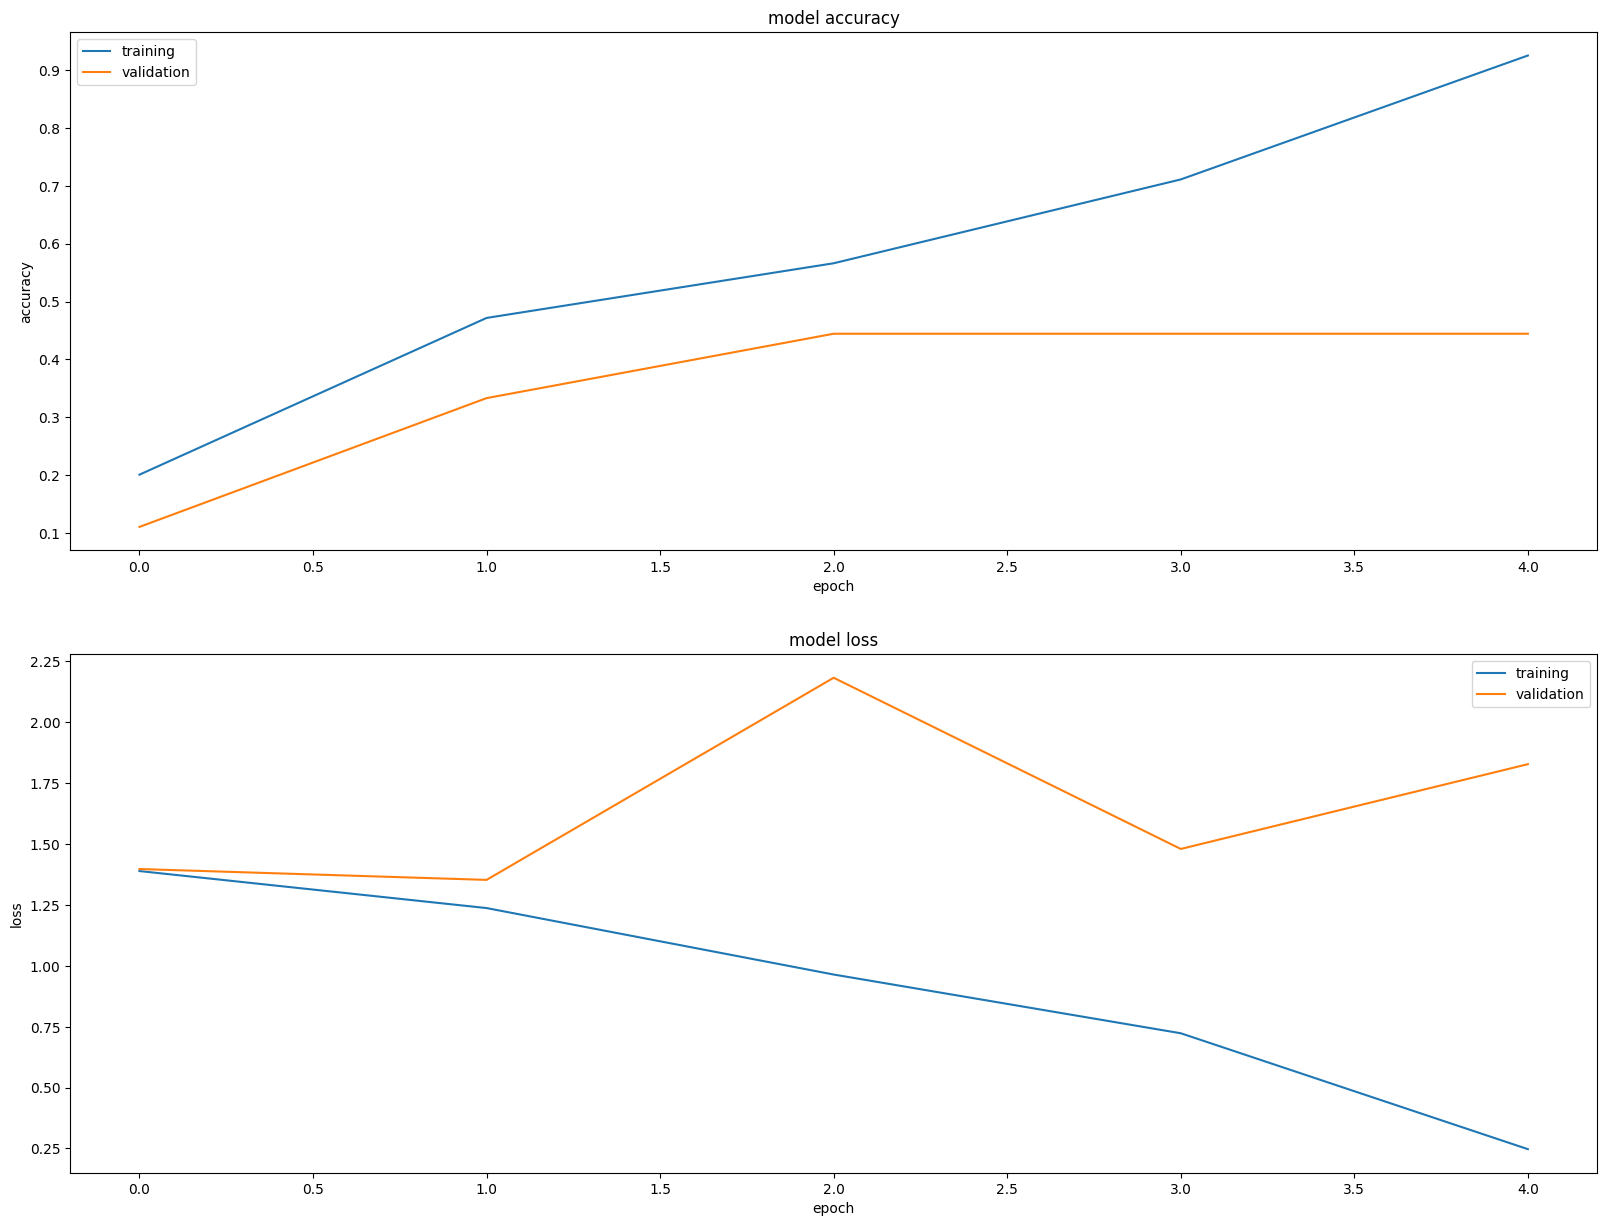

In [54]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history1.history['accuracy'], history1.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history1.history['loss'], history1.history['val_loss'], 'loss', 212)

## Confusion Matrix Post Model Performance Analysis

In [55]:
preds1 = model1.predict(test_ds_cat)
y_pred1= np.argmax(preds1, axis=1)
y1 = np.concatenate([y for x, y in test_ds_cat], axis=0)

6/6 [==============================] - 10s 21ms/step


In [56]:
GENRE_CLASSES_LIST = ['Action','Comedy','Horror','Sci Fi']

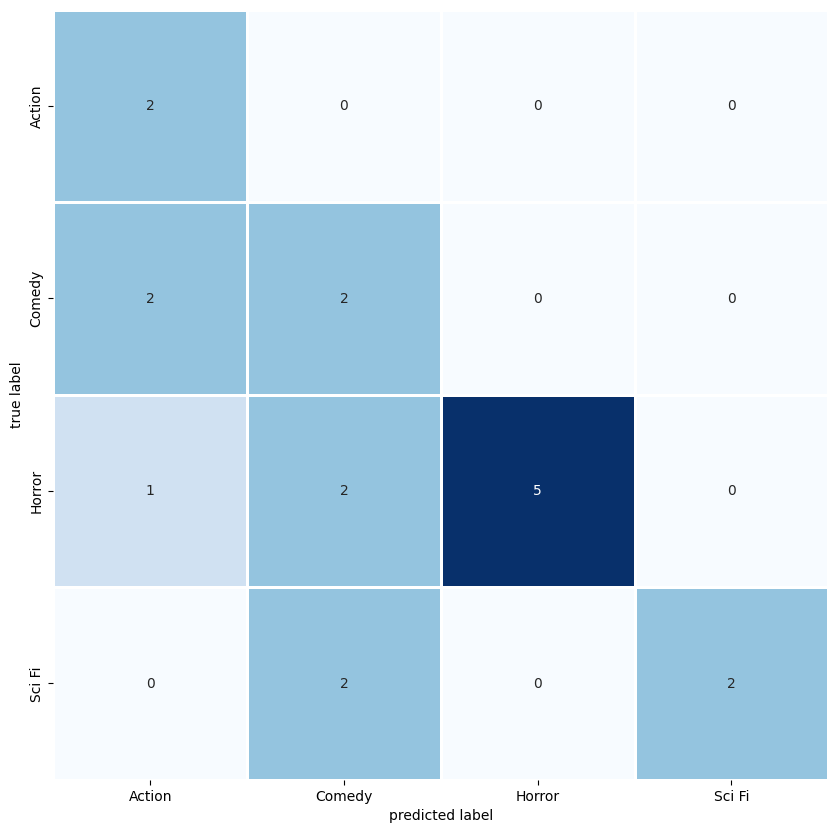

In [57]:
plot_confusion_matrix_labeled(y1, y_pred1, CLASSES_LIST=GENRE_CLASSES_LIST)

In [58]:
cm1= sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [59]:
df2 = pd.DataFrame(preds1[0:15]
                  ,columns = GENRE_CLASSES_LIST).T
df2.style.format("{:.2%}").background_gradient(cmap=cm1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Action,1.50%,1.64%,71.42%,2.41%,1.54%,1.71%,97.07%,9.61%,5.47%,95.30%,1.84%,2.23%,96.88%,0.17%,1.50%
Comedy,97.72%,97.02%,16.78%,41.38%,97.85%,3.87%,2.44%,8.21%,9.26%,3.81%,3.65%,4.33%,2.66%,1.40%,97.86%
Horror,0.33%,0.55%,8.37%,26.00%,0.26%,82.78%,0.15%,73.01%,72.15%,0.34%,85.33%,83.30%,0.14%,14.04%,0.27%
Sci Fi,0.45%,0.79%,3.43%,30.21%,0.35%,11.64%,0.34%,9.17%,13.11%,0.55%,9.18%,10.14%,0.33%,84.39%,0.36%


## RNN Model Architecture

In [60]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 bidirectional (Bidirection  (None, None, 128)         66048     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

In [61]:
print(classification_report(y1, y_pred1))

              precision    recall  f1-score   support

           0       0.40      1.00      0.57         2
           1       0.33      0.50      0.40         4
           2       1.00      0.62      0.77         8
           3       1.00      0.50      0.67         4

    accuracy                           0.61        18
   macro avg       0.68      0.66      0.60        18
weighted avg       0.79      0.61      0.64        18



## Build RNN Sequential Model To Predict Sentiment

In [62]:
k.clear_session()
model2=tf.keras.Sequential([encoder
   ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
   ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, dropout=0.3))
   ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout=0.3))
   ,tf.keras.layers.Dense(64, activation='relu')
   ,tf.keras.layers.Dense(1,activation='sigmoid')
])

In [63]:
model2.compile(optimizer= tf.keras.optimizers.Adam( )
              ,loss=tf.keras.losses.BinaryCrossentropy()
              ,metrics=['accuracy'])

In [64]:
%%time
history2 = model2.fit(train_ds_sent
         ,epochs=200
         ,validation_data=val_ds_sent
         ,validation_steps=3
         ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/200
53/53 [==============================] - 35s 300ms/step - loss: 0.6963 - accuracy: 0.4591 - val_loss: 0.6914 - val_accuracy: 0.5556
Epoch 2/200
53/53 [==============================] - 2s 43ms/step - loss: 0.6859 - accuracy: 0.6101 - val_loss: 0.7075 - val_accuracy: 0.3333
Epoch 3/200
53/53 [==============================] - 2s 43ms/step - loss: 0.4186 - accuracy: 0.8742 - val_loss: 1.3038 - val_accuracy: 0.3333
CPU times: user 37.2 s, sys: 894 ms, total: 38.1 s
Wall time: 39.3 s


In [65]:
test_loss2, test_acc2 = model2.evaluate(test_ds_sent)
train_loss2, train_acc2 = model2.evaluate(train_ds_sent)

print('Train Loss: {}'.format(round(train_loss2, 4)))
print('Test Loss: {}'.format(round(test_loss2,4)))

print('Train Accuracy: {}'.format(round(train_acc2, 4)))
print('Test Accuracy: {}'.format(round(test_acc2,4)))

53/53 [==============================] - 1s 18ms/step - loss: 0.1355 - accuracy: 0.9686
Train Loss: 0.1355
Test Loss: 0.9531
Train Accuracy: 0.9686
Test Accuracy: 0.4444


In [66]:
history_dict2 = history2.history
history_dict2.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [67]:
history_df2=pd.DataFrame(history_dict2)
history_df2.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.696,0.459,0.691,0.556
1,0.686,0.610,0.708,0.333
2,0.419,0.874,1.304,0.333


In [68]:
losses2 = history2.history['loss']
accs2 = history2.history['accuracy']
val_losses2 = history2.history['val_loss']
val_accs2= history2.history['val_accuracy']
epochs2 = len(losses2)

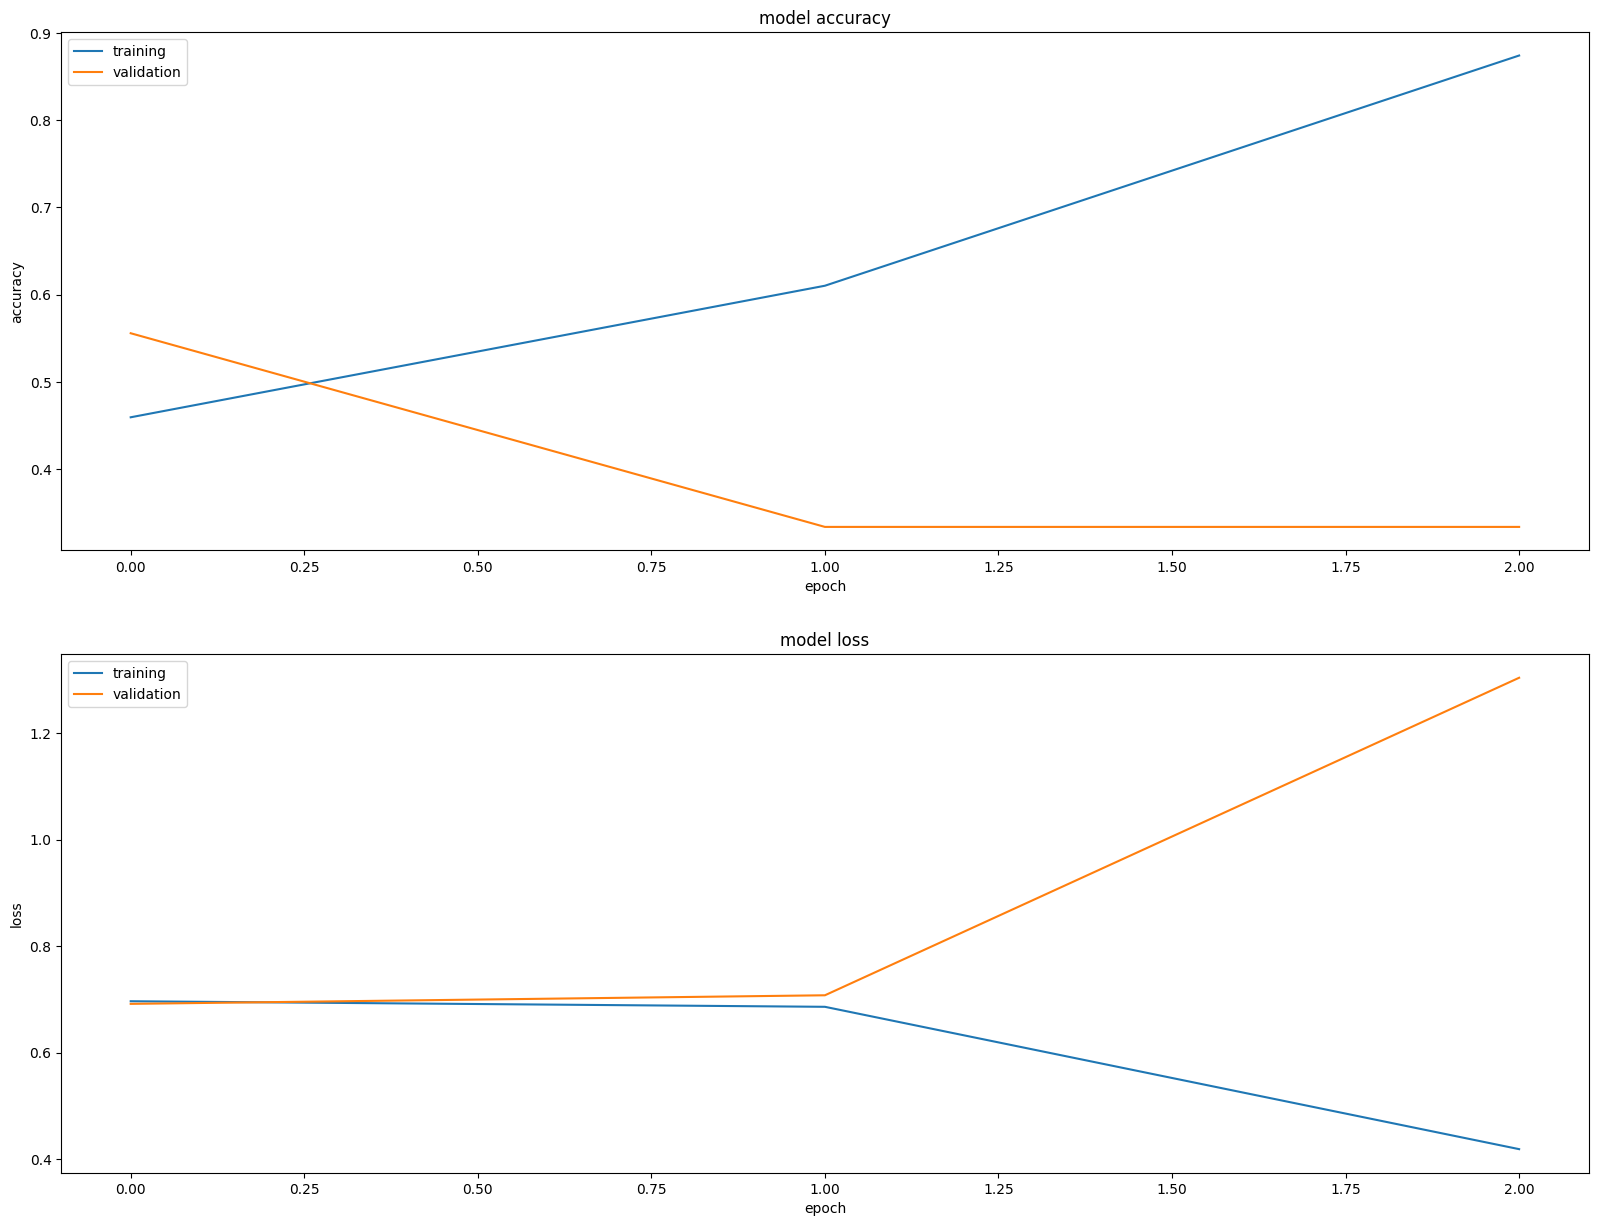

In [69]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history2.history['accuracy'], history2.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history2.history['loss'], history2.history['val_loss'], 'loss', 212)

In [70]:
preds2 = model2.predict(test_ds_sent)
threshold = 0.5
y_pred2 = (preds2  > threshold).astype(int)
y2 = np.concatenate([y for x, y in test_ds_sent], axis=0)

6/6 [==============================] - 7s 61ms/step


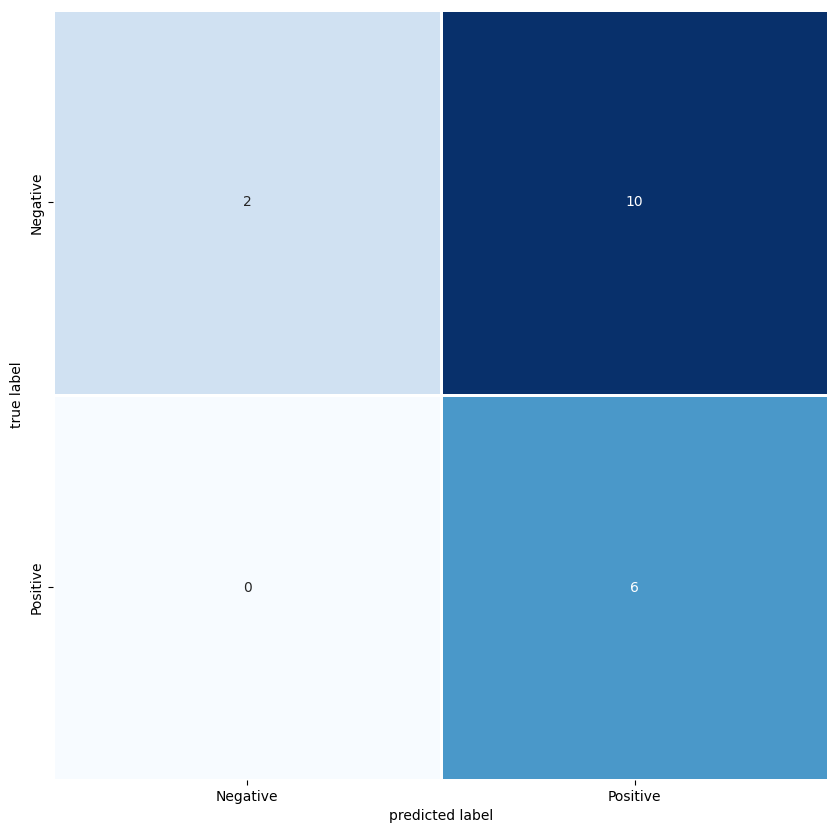

In [71]:
SENTIMENT_CLASSES_LIST = ['Negative', 'Positive']
plot_confusion_matrix_labeled(y2, y_pred2, CLASSES_LIST=SENTIMENT_CLASSES_LIST)

In [72]:
print(classification_report(y2, y_pred2))

              precision    recall  f1-score   support

           0       1.00      0.17      0.29        12
           1       0.38      1.00      0.55         6

    accuracy                           0.44        18
   macro avg       0.69      0.58      0.42        18
weighted avg       0.79      0.44      0.37        18

